In [1]:
from datetime import datetime
from functools import lru_cache
import io
import os
import sqlite3
from time import time

from dotenv import load_dotenv
from IPython.display import Image
import matplotlib.pyplot as plt
from pymongo import MongoClient
import requests

In [2]:
load_dotenv(verbose=True)

True

In [3]:
class WeatherGetter:
    """Interface for accessing Dark Sky historical weather data.
    
    [https://darksky.net/poweredby]"""
    LAT = 52.520008
    LON = 13.404954
    KEY = os.getenv('DARK_SKY_KEY')
        
    @classmethod
    @lru_cache(maxsize=None)
    def get_data(cls, dt):
        """Return daily data for Berlin on given datetime."""
        ts = int(dt.timestamp())
        url = ("https://api.darksky.net/forecast/" 
               f"{cls.KEY}/{cls.LAT},{cls.LON},{ts}"
               "?exclude=currently,hourly,flags")
        return requests.get(url).json()['daily']['data'][0]
    
    @classmethod
    def was_raining(cls, dt):
        """Return a bool whether there was precipitation on the input datetime."""
        return cls.get_data(dt)['precipIntensity'] > 0

In [4]:
class TeamData:
    """Extract data from Football Delphi dataset.
    
    [https://www.kaggle.com/laudanum/footballdelphi]"""
    def __init__(self, team_name):
        self.team_name = team_name
        self.conn = self._connection()
        self.cur = self.conn.cursor()       
        self.cur.executescript(
            f"""CREATE TEMP VIEW IF NOT EXISTS Team_Matches
            AS
            SELECT * FROM Bundesliga_2011 AS B
            JOIN Teams_in_Matches AS TIM  ON B.Match_ID=TIM.Match_ID
            JOIN Unique_Teams AS UT ON TIM.Unique_Team_ID=UT.Unique_Team_ID 
            WHERE UT.TeamName="{team_name}";""")
        
    @classmethod
    def _connection(cls):
        conn = sqlite3.connect('database.sqlite')
        conn.cursor().executescript(
            """CREATE TEMP VIEW IF NOT EXISTS Bundesliga_2011 
            AS
            SELECT * FROM Matches
            WHERE (Div="D1" OR Div="D2") AND Season=2011;""")
        return conn
    
    @classmethod
    def team_names(cls):
        """Return list of team names in alphabetical order."""
        return [r for (r,) in cls._connection().cursor().execute(
                                                """SELECT DISTINCT AwayTeam 
                                                FROM Bundesliga_2011 
                                                ORDER BY AwayTeam""").fetchall()]
    
    def _parse_match_date(self, datestr):
        return datetime.strptime(datestr, '%Y-%m-%d') # TODO: handle timezones
    
    def get_total_wins(self):
        """Return number of matches won in 2011 season."""
        return len(self.get_win_dates())
    
    def get_total_goals(self):
        """Return number of goals scored in 2011 season."""
        away_goals = self.cur.execute("""SELECT SUM(FTAG) FROM Team_Matches
                            WHERE AwayTeam=?""", (self.team_name,)).fetchone()[0]
        home_goals = self.cur.execute("""SELECT SUM(FTHG) FROM Team_Matches
                            WHERE HomeTeam=?""", (self.team_name,)).fetchone()[0]
        return away_goals + home_goals
    
    def get_loss_dates(self):
        """Return list of dates on which the team lost matches."""
        return [self._parse_match_date(d[0])
                for d in self.cur.execute("""SELECT Date FROM Team_Matches
                                            WHERE (AwayTeam=:team AND FTR="H") 
                                            OR (HomeTeam=:team AND FTR="A")""", 
                                            {'team': self.team_name}).fetchall()]
    
    def get_win_dates(self):
        """Return list of dates on which the team won matches."""
        return [self._parse_match_date(d[0])
                for d in self.cur.execute("""SELECT Date FROM Team_Matches
                                            WHERE (AwayTeam=:team AND FTR="A") 
                                            OR (HomeTeam=:team AND FTR="H")""", 
                                            {'team': self.team_name}).fetchall()]
    
    def get_match_dates(self):
        """Return list of dates on which the team played matches."""
        return [self._parse_match_date(d[0])
                for d in self.cur.execute("""SELECT Date FROM Team_Matches""").fetchall()]
    
    def get_win_rate(self, wet=True):
        """Return percentage of matches won, wet parameter selects rainy days or dry if False."""
        nmatches, nwins = 0, 0
        win_dates = set(self.get_win_dates())
        
        for d in self.get_match_dates():
            was_raining = WeatherGetter.was_raining(d)
            if wet and not was_raining or not wet and was_raining:
                    continue
            nmatches += 1
            if d in win_dates:
                nwins += 1
        
        return 100 * nwins / nmatches

In [5]:
class MongoHandler:
    def __init__(self):
        self.client = MongoClient(os.getenv('MONGODB_URI'))
        self.teams = self.client.bundesliga2011.teams
        
    def insert_team(self, team):
        self.teams.insert_one(team)
        
    def get_team(self, team_name):
        return self.teams.find_one({'name': team_name})

In [6]:
plt.style.use('bmh')


def hist_vis(team_name, win_dates, loss_dates):
    """Return bytes representing PNG image of histogram visualisation."""
    plt.figure(figsize=(13, 7))
    plt.hist([win_dates, loss_dates], 
             color=['green', 'red'], bins=9)
    plt.legend(['Wins', 'Losses'])
    plt.axis([datetime(2011,7,1), datetime(2012,6,1), 0, 9])
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.title(f"Wins and Losses for {team_name}")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    
    return buf.getvalue()

In [7]:
# team_name = TeamData.team_names()[6]
# td = TeamData(team_name)
# Image(hist_vis(team_name, td.get_win_dates(), td.get_loss_dates()))

In [8]:
def do_etl():
    etl_start = time()
    mh = MongoHandler()
    for name in TeamData.team_names():
        td = TeamData(name)
        print(f"{name}: creating png", end='')
        start = time()
        img_data = hist_vis(name, td.get_win_dates(), td.get_loss_dates())
        
        print(f" ({time() - start:.3}s). computing win rate", end='')
        start = time()
        win_rate = td.get_win_rate()
        
        print(f" ({time() - start:.3}s). goals, wins, and inserting record", end='')
        start = time()
        team = {
            'name': name,
            'goals': td.get_total_goals(),
            'wins': td.get_total_wins(),
            'histogramVisualisationPng': img_data,
            'winRateWhenRaining': win_rate
        }
        mh.insert_team(team)
        print(f" ({time() - start:.3}s).")
    print(f"\nCompleted ETL in {time() - etl_start:.3}s")

In [9]:
do_etl()

Aachen: creating png (0.273s). computing win rate (17.4s). goals, wins, and inserting record (0.086s).
Augsburg: creating png (0.258s). computing win rate (12.4s). goals, wins, and inserting record (0.049s).
Bayern Munich: creating png (0.243s). computing win rate (5.67s). goals, wins, and inserting record (0.053s).
Bochum: creating png (0.246s). computing win rate (7.83s). goals, wins, and inserting record (0.053s).
Braunschweig: creating png (0.238s). computing win rate (7.26s). goals, wins, and inserting record (0.043s).
Cottbus: creating png (0.242s). computing win rate (4.71s). goals, wins, and inserting record (0.052s).
Dortmund: creating png (0.247s). computing win rate (1.05s). goals, wins, and inserting record (0.0978s).
Dresden: creating png (0.274s). computing win rate (2.86s). goals, wins, and inserting record (0.0651s).
Duisburg: creating png (0.238s). computing win rate (1.5s). goals, wins, and inserting record (0.052s).
Ein Frankfurt: creating png (0.248s). computing win

{'_id': ObjectId('5e38e15154ad1ccf9d77c6ea'), 'name': 'Dortmund', 'goals': 80, 'wins': 25, 'winRateWhenRaining': 0}


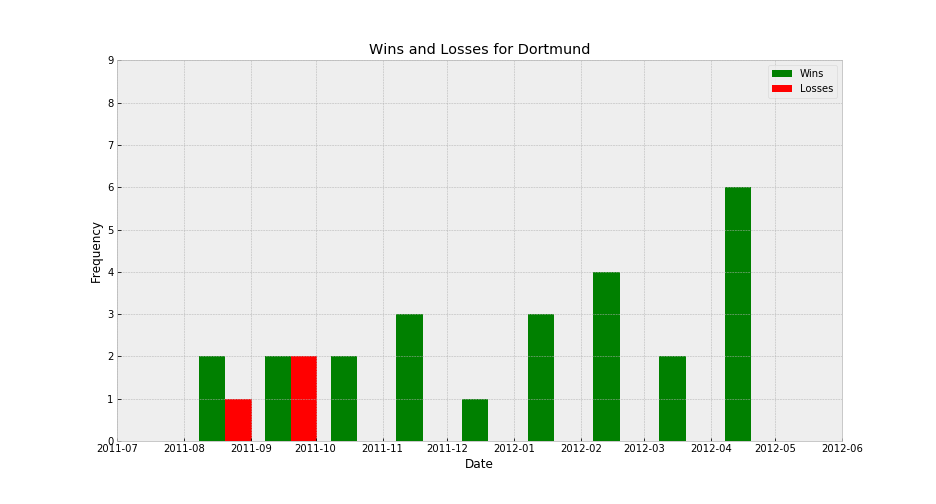

In [11]:
mh = MongoHandler()
team_name = TeamData.team_names()[6]
t = mh.get_team(team_name)
print({k:v for k, v in t.items() if k != 'histogramVisualisationPng'})
Image(t['histogramVisualisationPng'])